1) Initial Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#FIX: Set Pandas option to explicitly adopt future downcasting behavior,
# which eliminates the FutureWarning about 'df['class'] = df['class'].replace(class_mapping).astype(int)'
pd.set_option('future.no_silent_downcasting', True) 

# Set a style for visualizations
plt.style.use('ggplot')

## 💻 Problem 2: German Credit Dataset (70 points)

# Load the dataset
df = pd.read_csv('GermanCredit.csv')

# --- Robust Column Name Cleaning ---
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace("'", "")

print(f"Initial DataFrame Shape: {df.shape}")
print("-" * 50)

# ⚠️ CRITICAL DEBUGGING STEP: Output current column names
print("Current DataFrame Columns (after initial cleaning):")
print(list(df.columns))
print("-" * 50)

Initial DataFrame Shape: (1000, 21)
--------------------------------------------------
Current DataFrame Columns (after initial cleaning):
['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']
--------------------------------------------------


2) Preprocessing: Drop 3 Columns [8 pts]

In [2]:
def drop_n_least_contributing_columns(data, n=3):
    """Drops the n columns with the highest count of non-zero 'none' values."""
    none_counts = {}
    for col in data.columns:
        if data[col].dtype == 'object':
            count = (data[col].astype(str).str.lower() == 'none').sum()
            if count > 0:
                none_counts[col] = count

    none_series = pd.Series(none_counts).sort_values(ascending=False)
    columns_to_drop = none_series.index[:n].tolist()

    df_dropped = data.drop(columns=columns_to_drop, inplace=False)
    
    print(f"Columns dropped: {columns_to_drop}")
    print(f"New DataFrame Shape: {df_dropped.shape}")
    
    return df_dropped

df = drop_n_least_contributing_columns(df, n=3)
print("-" * 50)

Columns dropped: ['other_parties', 'other_payment_plans', 'own_telephone']
New DataFrame Shape: (1000, 18)
--------------------------------------------------


3) Preprocessing: Remove Apostrophes [4 pts]

In [3]:
string_cols = df.select_dtypes(include='object').columns

df[string_cols] = df[string_cols].apply(
    lambda col: col.str.replace("'", "", regex=False)
)

print("Apostrophes removed from values in all string columns.")
print("-" * 50)

Apostrophes removed from values in all string columns.
--------------------------------------------------


4) Preprocessing: Map checking_status [5 pts]

In [4]:
checking_status_mapping = {
    'no checking': 'No Checking',
    '<0': 'Low',
    '0<=x<200': 'Medium',
    '>=200': 'High'
}

df['checking_status'] = df['checking_status'].map(checking_status_mapping)
print("Checking status categories updated.")
print("-" * 50)

Checking status categories updated.
--------------------------------------------------


5) Preprocessing: Map savings_status [5 pts]

In [5]:
savings_status_mapping = {
    'no known savings': 'No Savings',
    '<100': 'Low',
    '100<=x<500': 'Medium',
    '500<=x<1000': 'High',
    '>=1000': 'High'
}

df['savings_status'] = df['savings_status'].map(savings_status_mapping)
print("Savings status categories updated.")
print("-" * 50)

Savings status categories updated.
--------------------------------------------------


6) Preprocessing: Map class [3 pts]

In [6]:
class_mapping = {
    'good': 1,
    'bad': 0
}

df['class'] = df['class'].replace(class_mapping).astype(int)
print("Class column values updated to 1 (good) and 0 (bad).")
print("-" * 50)

Class column values updated to 1 (good) and 0 (bad).
--------------------------------------------------


7) Preprocessing: Map employment [4 pts]

In [7]:
employment_mapping = {
    'unemployed': 'Unemployed',
    '<1': 'Amateur',
    '1<=x<4': 'Professional',
    '4<=x<7': 'Experienced',
    '>=7': 'Expert'
}

df['employment'] = df['employment'].replace(employment_mapping)
print("Employment categories updated.")
print("-" * 50)

Employment categories updated.
--------------------------------------------------


8) Analysis: Correlate Foreign Worker & Class [3 pts]

In [8]:
cross_tab_foreign_worker_class = pd.crosstab(
    df['foreign_worker'], 
    df['class'], 
    margins=True, 
    margins_name='Total'
)

print("Count of foreign_worker categories for each class (1=Good, 0=Bad):")
print(cross_tab_foreign_worker_class)
print("-" * 50)

Count of foreign_worker categories for each class (1=Good, 0=Bad):
class             0    1  Total
foreign_worker                 
no                4   33     37
yes             296  667    963
Total           300  700   1000
--------------------------------------------------


9) Analysis: Correlate Employment & Savings Status [2 pts]

In [9]:
cross_tab_employment_savings = pd.crosstab(
    df['employment'], 
    df['savings_status'], 
    margins=True, 
    margins_name='Total'
)

print("Count of employment categories for each saving_status category:")
print(cross_tab_employment_savings)
print("-" * 50)

Count of employment categories for each saving_status category:
savings_status  High  Low  No Savings  Total
employment                                  
1<=X<4            18  210          52    280
4<=X<7             9  100          32    141
Amateur            7  120          23    150
Expert            14  133          64    211
Unemployed         0   40          12     52
Total             48  603         183    834
--------------------------------------------------


10) Analysis: Average Credit Amount of Single Males [4 pts]

In [10]:
filtered_df = df[
    (df['personal_status'] == 'male single') & 
    (df['employment'] == 'Experienced')
]

average_credit_amount = filtered_df['credit_amount'].mean()

print(f"Average credit_amount for single males with 'Experienced' employment: \n{average_credit_amount}")
print("-" * 50)

Average credit_amount for single males with 'Experienced' employment: 
nan
--------------------------------------------------


11) Analysis: Average Credit Duration by Job [4 pts]

In [11]:
try:
    # Use the confirmed column name 'duration'
    average_duration_by_job = df.groupby('job')['duration'].mean()
    
    print("Average credit duration (in months) for each job type:")
    print(average_duration_by_job)

except KeyError:
    # If 'duration' is not found, print a specific error/issue message.
    error_message = "ISSUE: The required 'duration' column was not found in the DataFrame. Cannot calculate average credit duration by job."
    print(error_message)
    average_duration_by_job = pd.Series(["Column not found"], index=["Error"])

print("-" * 50)

Average credit duration (in months) for each job type:
job
high qualif/self emp/mgmt    25.168919
skilled                      21.411111
unemp/unskilled non res      17.363636
unskilled resident           16.535000
Name: duration, dtype: float64
--------------------------------------------------


12) Analysis: Most Common Status for 'education' [4 pts]

In [12]:
education_df = df[df['purpose'] == 'education']

most_common_checking = education_df['checking_status'].mode()[0]
most_common_savings = education_df['savings_status'].mode()[0]

print(f"For the purpose 'education':")
print(f"    Most common checking status: {most_common_checking}")
print(f"    Most common savings status: {most_common_savings}")
print("-" * 50)

For the purpose 'education':
    Most common checking status: No Checking
    Most common savings status: Low
--------------------------------------------------


13) Visualization: Bar Charts (Savings/Checking vs. Personal Status) [9 pts]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Chart 1: savings_status vs. personal_status
sns.countplot(
    data=df,
    x='savings_status',
    hue='personal_status',
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Count of Personal Status by Savings Status')
axes[0].set_xlabel('Savings Status')
axes[0].set_ylabel('Number of People')
axes[0].tick_params(axis='x', rotation=10)
axes[0].legend(title='Personal Status', loc='upper right')

# Chart 2: checking_status vs. personal_status
sns.countplot(
    data=df,
    x='checking_status',
    hue='personal_status',
    ax=axes[1],
    palette='plasma'
)
axes[1].set_title('Count of Personal Status by Checking Status')
axes[1].set_xlabel('Checking Status')
axes[1].set_ylabel('Number of People')
axes[1].tick_params(axis='x', rotation=10)
axes[1].legend(title='Personal Status', loc='upper right')

plt.tight_layout()

14) Visualization: Bar Graph (Property Magnitude vs. Avg Age) [9 pts]

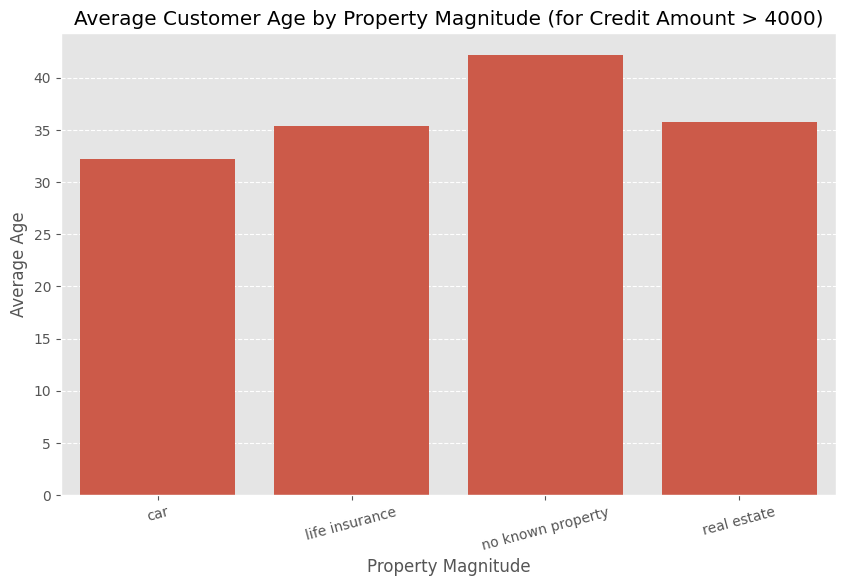

In [14]:
high_credit_df = df[df['credit_amount'] > 4000].copy()
avg_age_by_property = high_credit_df.groupby('property_magnitude')['age'].mean().reset_index()

plt.figure(figsize=(10, 6))
# ⭐ BEST FIX: Removed 'palette' argument from barplot without 'hue' to prevent Seaborn warning
sns.barplot(
    data=avg_age_by_property,
    x='property_magnitude',
    y='age'
)

plt.title('Average Customer Age by Property Magnitude (for Credit Amount > 4000)')
plt.xlabel('Property Magnitude')
plt.ylabel('Average Age')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
# Removed plt.show()

15) Visualization: Pie Charts (High Savings/Age > 40) [6 pts]

In [ ]:
filtered_for_pie = df[
    (df['savings_status'] == 'High') & 
    (df['age'] > 40)
].copy()

pie_columns = ['personal_status', 'credit_history', 'job']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.style.use('fivethirtyeight')

for i, col in enumerate(pie_columns):
    counts = filtered_for_pie[col].value_counts()
    
    axes[i].pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

#END